In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns

import sys
sys.path.append("../../../../../src")

import nanonets_utils

from scipy import signal
from sklearn.decomposition import PCA
from scipy.interpolate import interp1d

plt.style.use(["science","bright"])

def load_time_series(path, N_threads, samples_per_thread, N_p, skip_eq=0):
    n   = 0
    dic = {}
    for i in range(N_threads):
        for j in range(samples_per_thread):
            df      =   pd.read_csv(f"{path}Nx={N_p}_Ny={N_p}_Nz=1_Ne=8_{i}_{j}.csv")
            dic[n]  =   df.iloc[skip_eq:,:].reset_index(drop=True)
            n       +=  1
    return dic

def load_states(path, N_threads, samples_per_thread, N_p, skip_eq=0):
    n   = 0
    dic = {}
    for i in range(N_threads):
        for j in range(samples_per_thread):
            df      =   pd.read_csv(f"{path}mean_state_Nx={N_p}_Ny={N_p}_Nz=1_Ne=8_{i}_{j}.csv")
            dic[n]  =   df.iloc[skip_eq:,:].reset_index(drop=True)
            n       +=  1
    return dic

def return_best_fit(y_real_arr, y_target):
    y_target    = nanonets_utils.standard_norm(y_target)
    rmse        = []

    for i in range(y_real_arr.shape[1]):
        y_real  = y_real_arr[:,i].copy()
        y_real  = nanonets_utils.standard_norm(y_real)
        rmse.append(np.sqrt(np.sum((y_real-y_target)**2)))

    return np.argsort(rmse), rmse 

In [2]:
param   = "const"
N_th    = 36
n_p_t   = 2
N_p     = 11
t_step  = 1e-7
skip_eq = 8000
# folder  = f"/home/j/j_mens07/phd/data/2_funding_period/potential/magic_cable/sine/{param}/"
# folder  = f"/mnt/c/Users/jonas/Desktop/phd/data/2_funding_period/potential/magic_cable/sine/{param}/"
folder  = f"/home/j/j_mens07/phd/data/2_funding_period/potential/magic_cable/sine/{param}/"
data    = load_time_series(folder, N_th, n_p_t, N_p, skip_eq)
t_vals  = np.arange(len(data[0]))*1e-7*1e6

## Harmonic Strength

In [3]:
N_f         = 10
N_volt      = N_th*n_p_t
h_strength  = np.zeros(shape=(N_volt,N_f))
f0          = 1e5
arr         = data[2]['Current'].values*1000

for i, (key, df) in enumerate(data.items()):

    arr             = df['Current'].values
    val             = nanonets_utils.harmonic_strength(signal=arr, f0=f0, dt=t_step, N_f=10, dB=False)
    h_strength[i,:] = val

df_harm = pd.DataFrame(h_strength)
df_harm

,0,1,2,3,4,5,6,7,8,9
0,0.063768,0.060708,0.009460,0.003548,0.000459,0.000656,0.000181,0.000159,0.000562,0.000331
1,0.059653,0.058068,0.006694,0.000443,0.001709,0.000203,0.000891,0.000108,0.000345,0.000217
2,0.026374,0.022014,0.016113,0.005696,0.000729,0.001381,0.001423,0.000955,0.000368,0.000137
3,0.147548,0.036064,0.004721,0.002040,0.000534,0.000348,0.000264,0.000119,0.000142,0.000038
4,0.104854,0.026843,0.009744,0.000640,0.001817,0.000587,0.000560,0.000356,0.000123,0.000249
...,...,...,...,...,...,...,...,...,...,...
67,0.069303,0.040291,0.005156,0.003882,0.001167,0.000789,0.000368,0.000736,0.000096,0.000466
68,0.048258,0.062555,0.001674,0.000856,0.001067,0.002189,0.000740,0.000498,0.000817,0.000141
69,0.057080,0.036517,0.002693,0.005045,0.000527,0.001152,0.000428,0.000564,0.000138,0.000696
70,0.130884,0.024357,0.005182,0.000716,0.000620,0.000246,0.000501,0.000377,0.000130,0.000204


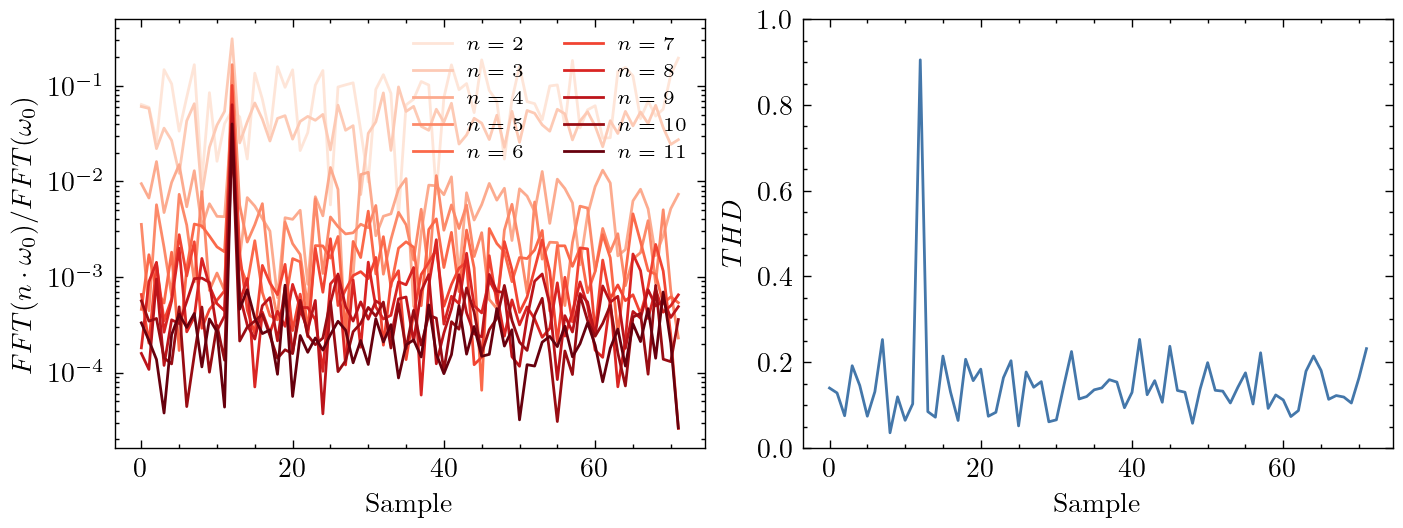

In [4]:
cmap    = plt.get_cmap("Reds")
fig     = plt.figure(dpi=200, layout='constrained')
ax      = fig.add_subplot(1,2,1)
fig.set_figwidth(fig.get_figwidth()*2)

for i in range(N_f):
    ax.plot(df_harm[i], c=cmap((i+1)/N_f), label=f"$n = {i+2}$")

ax.set_yscale("log")
ax.set_xlabel('Sample')
ax.set_ylabel('$FFT(n \cdot \omega_0)/FFT(\omega_0)$')
ax.legend(fontsize='x-small', ncol=2)

ax  = fig.add_subplot(1,2,2)
ax  = df_harm.sum(axis=1).plot(ax=ax)
ax.set_ylim(0,1)
ax.set_xlabel('Sample')
ax.set_ylabel('$THD$')

fig.savefig("../plots/sine/harmonic_strength_vs_sample.svg", transparent=True, bbox_inches='tight')
fig.savefig("../plots/sine/harmonic_strength_vs_sample.pdf", transparent=False, bbox_inches='tight')

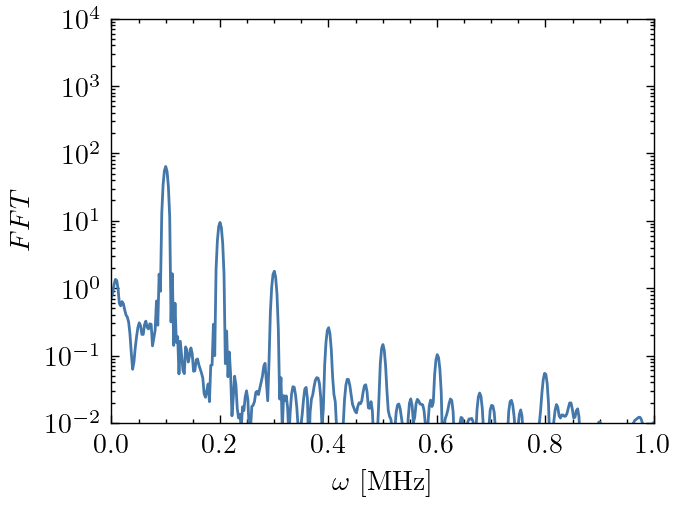

In [5]:
idx     =   20
arr     =   data[idx]['Current'].values*1000
arr     -=  np.mean(arr)
xf, yf  =   nanonets_utils.fft(signal=arr, dt=t_step, n_padded=4096, use_hann=True)
xf      /=  1e6

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(xf, yf)
ax.set_xlabel("$\omega$ [MHz]")
ax.set_yscale("log")
ax.set_xlim(0,1)
ax.set_ylim(1e-2, 1e4)
ax.set_ylabel("$FFT$")

fig.savefig(f"../plots/sine/FFT_{idx}.svg", transparent=True, bbox_inches='tight')
fig.savefig(f"../plots/sine/FFT_{idx}.pdf", transparent=False, bbox_inches='tight')

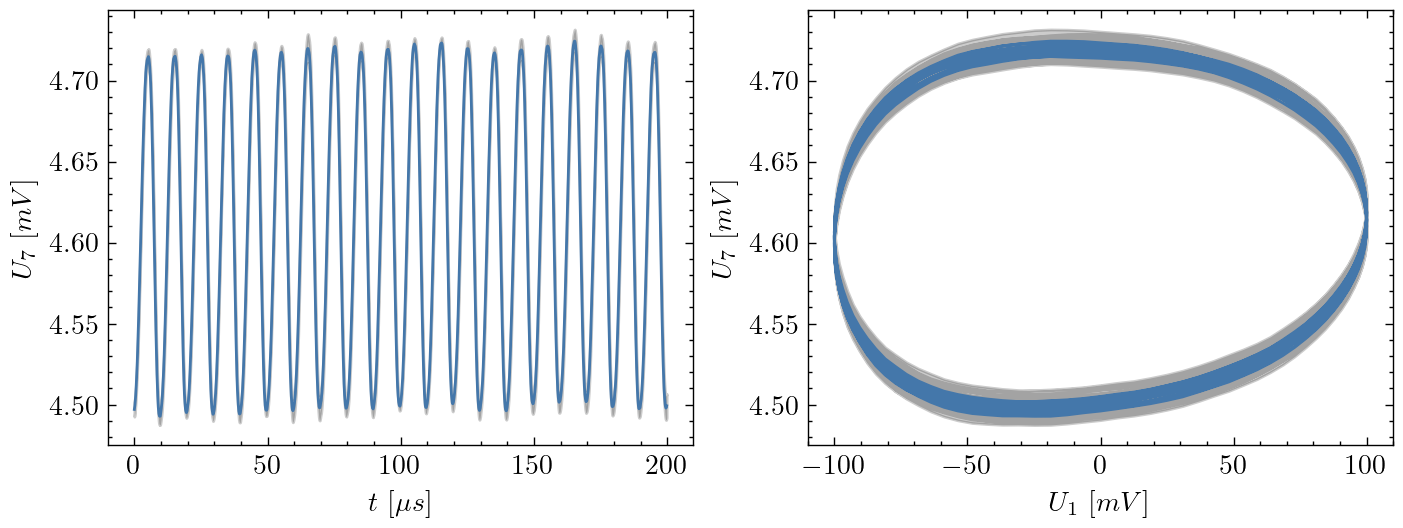

In [69]:
idx     = 40
x_val   = data[idx]['E0'].values*1000
val     = data[idx]['Current'].values*1000
val_e   = data[idx]['Error'].values*1000

fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
ax  = fig.add_subplot(1,2,1)
ax.plot(t_vals, val)
ax.fill_between(t_vals, val-val_e, val+val_e, color='black', alpha=0.2)
ax.set_xlabel('$t$ [$\mu s$]')
ax.set_ylabel('$U_7$ [$mV$]')

ax  = fig.add_subplot(1,2,2)
ax.plot(x_val, val)
ax.fill_between(x_val, val-val_e, val+val_e, color='black', alpha=0.2)
ax.set_xlabel('$U_1$ [$mV$]')
ax.set_ylabel('$U_7$ [$mV$]')

fig.savefig(f"../plots/sine/output_{idx}.svg", transparent=True, bbox_inches='tight')
fig.savefig(f"../plots/sine/output_{idx}.pdf", transparent=False, bbox_inches='tight')

In [7]:
states  = load_states(folder, N_th, n_p_t, N_p, skip_eq=skip_eq)

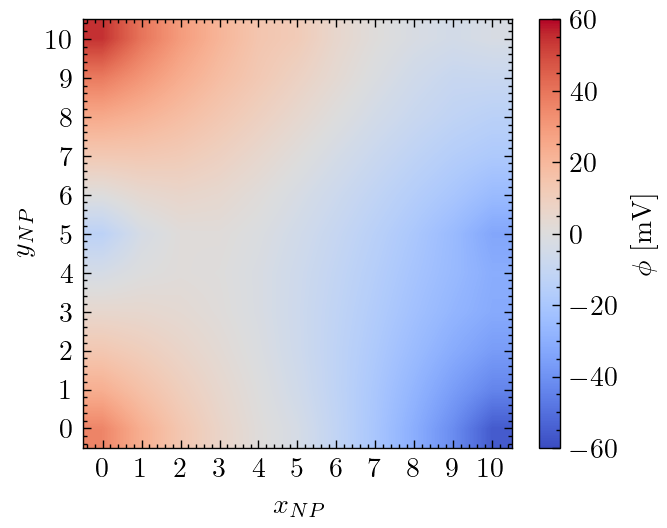

In [67]:
idx         = 40
arr         = states[idx].values[:,:-1]
landscape   = arr.mean(axis=0).reshape(11,-1)*1000

fig = plt.figure(dpi=200, layout='constrained')
ax  = fig.add_subplot()
im  = ax.imshow(landscape, origin='lower', cmap='coolwarm', vmin=-60, vmax=60, interpolation='bilinear')

ax.set_xlabel("$x_{NP}$")
ax.set_ylabel("$y_{NP}$")
ax.set_xticks(np.arange(11))
ax.set_yticks(np.arange(11))

fig.colorbar(im, label='$\phi$ [mV]')
fig.savefig(f"../plots/sine/landscape/pot_landscape_{idx}.svg", transparent=True, bbox_inches='tight')
fig.savefig(f"../plots/sine/landscape/pot_landscape_{idx}.pdf", transparent=False, bbox_inches='tight')

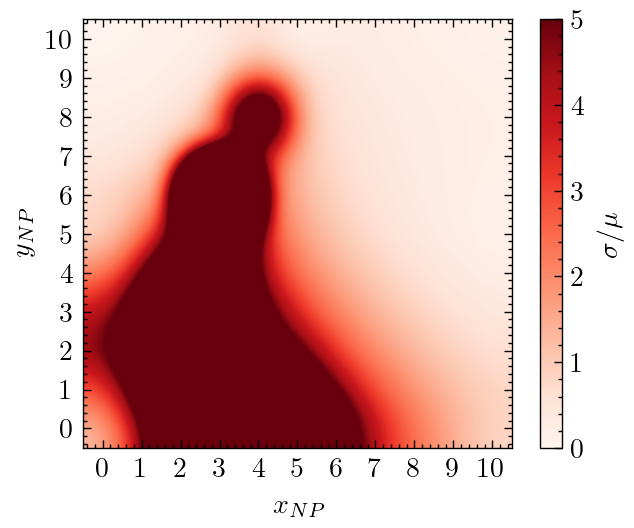

In [65]:
idx         = 30
arr         = states[idx].values[:,:-1]
arr_stat    = np.abs(arr.std(axis=0) / arr.mean(axis=0))
landscape   = arr_stat.reshape(11,-1)

fig = plt.figure(dpi=200, layout='constrained')
ax  = fig.add_subplot()
im  = ax.imshow(landscape, origin='lower', cmap='Reds', vmin=0, vmax=5, interpolation='bicubic')

ax.set_xlabel("$x_{NP}$")
ax.set_ylabel("$y_{NP}$")
ax.set_xticks(np.arange(11))
ax.set_yticks(np.arange(11))

fig.colorbar(im, label='$\sigma / \mu$')
fig.savefig(f"../plots/sine/landscape/pot_landscape_std_{idx}.svg", transparent=True, bbox_inches='tight')
fig.savefig(f"../plots/sine/landscape/pot_landscape_std_{idx}.pdf", transparent=False, bbox_inches='tight')

## Voltages

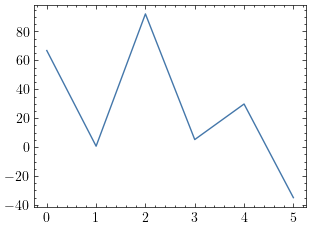

In [10]:
voltage = data[12].loc[0,'E1':'E6'].values*1000
plt.plot(voltage)

## Train

In [11]:
# y_target        = 10*signal.square(2*np.pi*t_vals*0.1)
# y_target        = 10*signal.sawtooth(2*np.pi*t_vals*0.1)
# y_target        = 10*signal.sawtooth(2*np.pi*t_vals*0.1, 0.5)
# fit_order, rmse = return_best_fit(y_real_arr=arr1, y_target=y_target)
# best_idx        = fit_order[1]

In [12]:
# y_1 = scale(y_target)
# y_2 = scale(arr1[:,best_idx])

# fig = plt.figure(dpi=200, layout='constrained')
# fig.set_figwidth(fig.get_figwidth()*2)

# ax  = fig.add_subplot()
# ax.plot(t_vals, y_1)
# ax.plot(t_vals, y_2)
# ax.set_xlabel('$t$ [$\mu s$]')